<center><h1>Thai_Khang_HW8</h1></center>

Name: Khang Thai
<br>
Github Username: kunfupen
<br>
USC ID: 5721113147

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import ConvergenceWarning

### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

In [2]:
data = Path(r"..\Homework 8 Data\wdbc.data")
df = pd.read_csv(data, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### (b) Monte-Carlo Simulation

#### (i) Supervised Learning

Accuracy - Train: 0.9816 ± 0.0046, Test: 0.9661 ± 0.0128
Precision - Train: 0.9974 ± 0.0037, Test: 0.9876 ± 0.0155
Recall - Train: 0.9533 ± 0.0127, Test: 0.9198 ± 0.0345
F1 - Train: 0.9748 ± 0.0065, Test: 0.9521 ± 0.0189
Auc - Train: 0.9972 ± 0.0011, Test: 0.9940 ± 0.0062


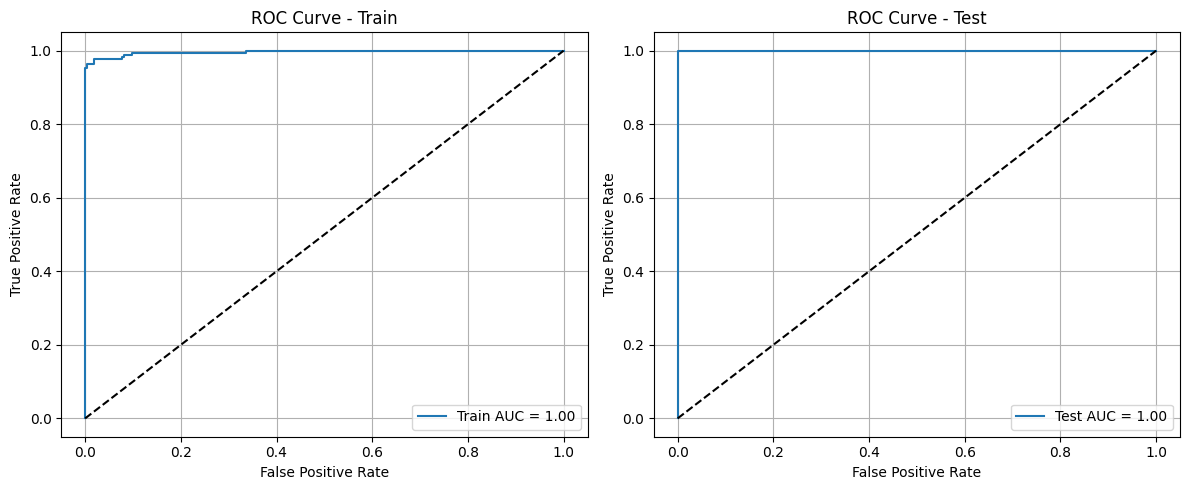

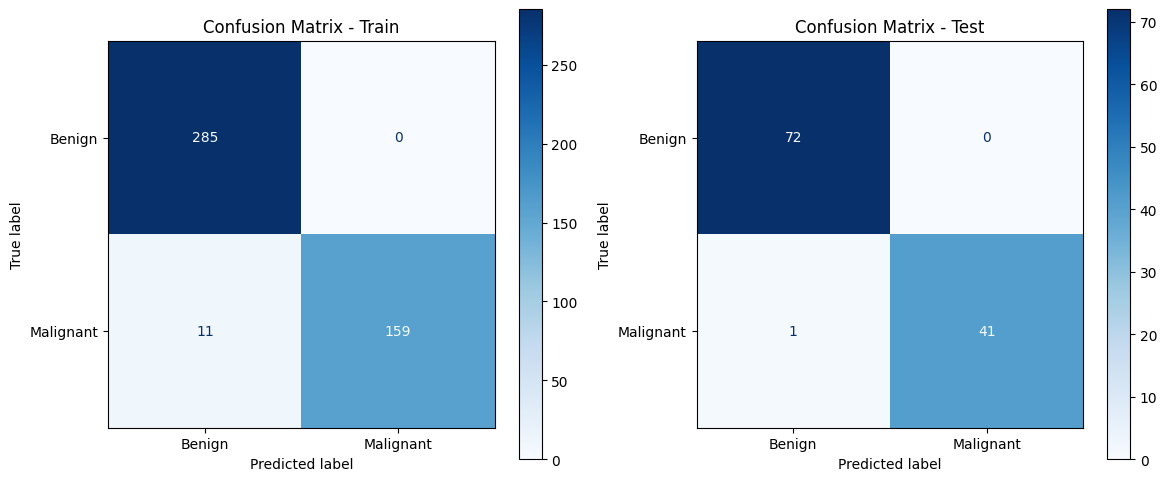

In [3]:
column_names = ['ID', 'Diagnosis']
features = ['radius', 'texture', 'perimeter', 'area', 'smoothness',
            'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension']

for feature in features:
    column_names.append(f'{feature}_mean')
for feature in features:
    column_names.append(f'{feature}_se')
for feature in features:
    column_names.append(f'{feature}_worst')

df.columns = column_names

x = df.drop(['ID', 'Diagnosis'], axis=1).values
y = (df['Diagnosis'] == 'M').astype(int).values

M = 30
np.random.seed(42)

res_supervised = {
    'train': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []},
    'test': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
}

for run in range(M):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, stratify=y, random_state=run
    )

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

    svm_l1 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=run)

    grid = GridSearchCV(svm_l1, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train_scaled, y_train)

    best_svm = grid.best_estimator_

    calibrated_svm = CalibratedClassifierCV(best_svm, cv = 3)
    calibrated_svm.fit(x_train_scaled, y_train)

    y_train_pred = calibrated_svm.predict(x_train_scaled)
    y_test_pred = calibrated_svm.predict(x_test_scaled)

    y_train_proba = calibrated_svm.predict_proba(x_train_scaled)[:, 1]
    y_test_proba = calibrated_svm.predict_proba(x_test_scaled)[:, 1]

    res_supervised['train']['accuracy'].append(accuracy_score(y_train, y_train_pred))
    res_supervised['train']['precision'].append(precision_score(y_train, y_train_pred))
    res_supervised['train']['recall'].append(recall_score(y_train, y_train_pred))
    res_supervised['train']['f1'].append(f1_score(y_train, y_train_pred))
    res_supervised['train']['auc'].append(roc_auc_score(y_train, y_train_proba))

    res_supervised['test']['accuracy'].append(accuracy_score(y_test, y_test_pred))
    res_supervised['test']['precision'].append(precision_score(y_test, y_test_pred))
    res_supervised['test']['recall'].append(recall_score(y_test, y_test_pred))
    res_supervised['test']['f1'].append(f1_score(y_test, y_test_pred))
    res_supervised['test']['auc'].append(roc_auc_score(y_test, y_test_proba))

for metrics in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    train_mean = np.mean(res_supervised['train'][metrics])
    train_std = np.std(res_supervised['train'][metrics])
    test_mean = np.mean(res_supervised['test'][metrics])
    test_std = np.std(res_supervised['test'][metrics])
    
    print(f"{metrics.capitalize()} - Train: {train_mean:.4f} ± {train_std:.4f}, Test: {test_mean:.4f} ± {test_std:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
auc_train = roc_auc_score(y_train, y_train_proba)
axes[0].plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_title('ROC Curve - Train')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid()

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
auc_test = roc_auc_score(y_test, y_test_proba)
axes[1].plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title('ROC Curve - Test')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Benign', 'Malignant'])
disp_train.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Confusion Matrix - Train')

cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Benign', 'Malignant'])
disp_test.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('Confusion Matrix - Test')

plt.tight_layout()
plt.show()


#### (ii) Semi-Supervised Learning/ Self-training

##### (A)

In [4]:
res_semi_a = {
    'train': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []},
    'test': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
}


for run in range(M):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, stratify=y, random_state=run
    )

    pos_idx = np.where(y_train == 1)[0]
    neg_idx = np.where(y_train == 0)[0]

    np.random.seed(run)

    n_pos_labeled = len(pos_idx) // 2
    n_neg_labeled = len(neg_idx) // 2

    pos_labeled_idx = np.random.choice(pos_idx, n_pos_labeled, replace=False)
    neg_labeled_idx = np.random.choice(neg_idx, n_neg_labeled, replace=False)

    labeled_idx = np.concatenate([pos_labeled_idx, neg_labeled_idx])
    unlabeled_idx = np.setdiff1d(np.arange(len(y_train)), labeled_idx)

    x_labeled = x_train[labeled_idx]
    y_labeled = y_train[labeled_idx]
    x_unlabeled = x_train[unlabeled_idx]
    y_unlabeled = y_train[unlabeled_idx]

    scaler = StandardScaler()
    x_labeled_scaled = scaler.fit_transform(x_labeled)
    x_unlabeled_scaled = scaler.transform(x_unlabeled)
    x_test_scaled = scaler.transform(x_test)

    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    svm_l1 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=run)

    grid = GridSearchCV(svm_l1, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(x_labeled_scaled, y_labeled)
    best_svm = grid.best_estimator_

    calibrated_svm = CalibratedClassifierCV(best_svm, cv=3)
    calibrated_svm.fit(x_labeled_scaled, y_labeled)

    y_labeled_pred = calibrated_svm.predict(x_labeled_scaled)
    y_test_pred = calibrated_svm.predict(x_test_scaled)
    y_labeled_proba = calibrated_svm.predict_proba(x_labeled_scaled)[:, 1]
    y_test_proba = calibrated_svm.predict_proba(x_test_scaled)[:, 1]

    res_semi_a['train']['accuracy'].append(accuracy_score(y_labeled, y_labeled_pred))
    res_semi_a['train']['precision'].append(precision_score(y_labeled, y_labeled_pred))
    res_semi_a['train']['recall'].append(recall_score(y_labeled, y_labeled_pred))
    res_semi_a['train']['f1'].append(f1_score(y_labeled, y_labeled_pred))
    res_semi_a['train']['auc'].append(roc_auc_score(y_labeled, y_labeled_proba))

    res_semi_a['test']['accuracy'].append(accuracy_score(y_test, y_test_pred))
    res_semi_a['test']['precision'].append(precision_score(y_test, y_test_pred))
    res_semi_a['test']['recall'].append(recall_score(y_test, y_test_pred))
    res_semi_a['test']['f1'].append(f1_score(y_test, y_test_pred))
    res_semi_a['test']['auc'].append(roc_auc_score(y_test, y_test_proba))

for metrics in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    train_mean = np.mean(res_semi_a['train'][metrics])
    train_std = np.std(res_semi_a['train'][metrics])
    test_mean = np.mean(res_semi_a['test'][metrics])
    test_std = np.std(res_semi_a['test'][metrics])
    
    print(f"Semi-supervised {metrics.capitalize()} - Train: {train_mean:.4f} ± {train_std:.4f}, Test: {test_mean:.4f} ± {test_std:.4f}")

Semi-supervised Accuracy - Train: 0.9793 ± 0.0081, Test: 0.9605 ± 0.0164
Semi-supervised Precision - Train: 0.9983 ± 0.0042, Test: 0.9897 ± 0.0142
Semi-supervised Recall - Train: 0.9463 ± 0.0203, Test: 0.9024 ± 0.0414
Semi-supervised F1 - Train: 0.9715 ± 0.0114, Test: 0.9435 ± 0.0247
Semi-supervised Auc - Train: 0.9966 ± 0.0029, Test: 0.9924 ± 0.0069


##### (B)

c:\Users\kunfu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\kunfu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Semi-supervised Iterative Accuracy - Train: 0.9873 ± 0.0068, Test: 0.9614 ± 0.0119
Semi-supervised Iterative Precision - Train: 0.9971 ± 0.0047, Test: 0.9702 ± 0.0295
Semi-supervised Iterative Recall - Train: 0.9683 ± 0.0142, Test: 0.9246 ± 0.0139
Semi-supervised Iterative F1 - Train: 0.9824 ± 0.0092, Test: 0.9466 ± 0.0158
Semi-supervised Iterative Auc - Train: 0.9981 ± 0.0014, Test: 0.9919 ± 0.0023


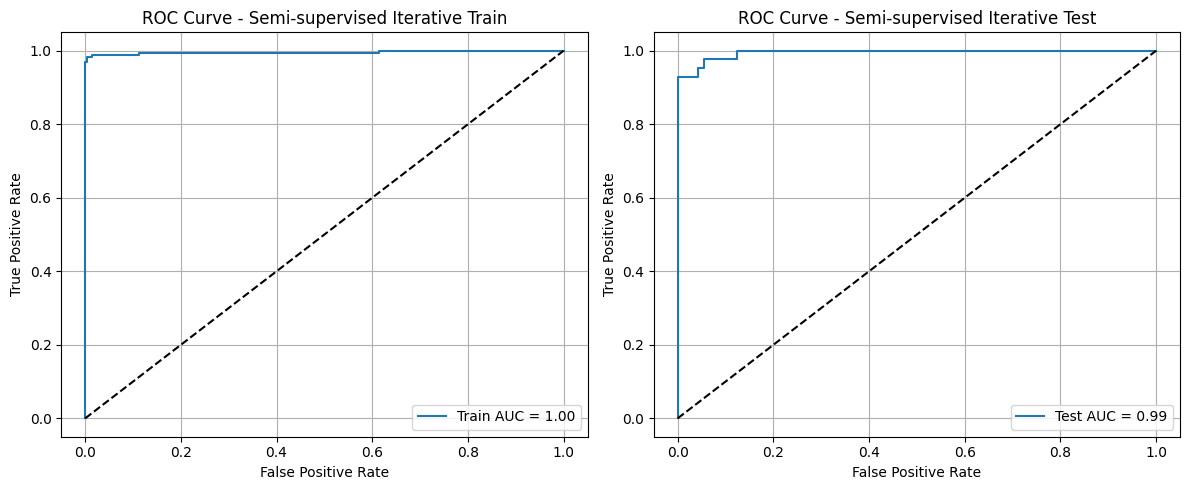

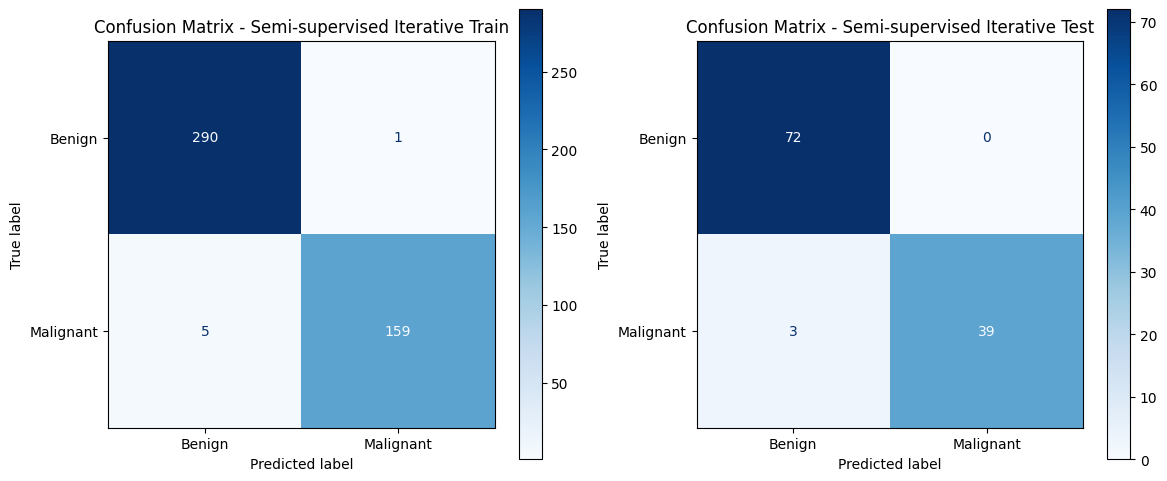

In [5]:
res_semi_b = {
    'train': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []},
    'test': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
}

for run in range(M):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, stratify=y, random_state=0
    )

    pos_idx = np.where(y_train == 1)[0]
    neg_idx = np.where(y_train == 0)[0]

    np.random.seed(run)

    n_pos_labeled = len(pos_idx) // 2
    n_neg_labeled = len(neg_idx) // 2

    pos_labeled_idx = np.random.choice(pos_idx, n_pos_labeled, replace=False)
    neg_labeled_idx = np.random.choice(neg_idx, n_neg_labeled, replace=False)

    labeled_idx = np.concatenate([pos_labeled_idx, neg_labeled_idx])
    unlabeled_idx = np.setdiff1d(np.arange(len(y_train)), labeled_idx)

    x_labeled = x_train[labeled_idx]
    y_labeled = y_train[labeled_idx]
    x_unlabeled = x_train[unlabeled_idx]

    scaler = StandardScaler()
    scaler.fit(x_labeled)

    x_labeled_scaled = scaler.transform(x_labeled)
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    svm_l1 = LinearSVC(penalty='l1', dual=False, max_iter=10000, random_state=0)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    grid = GridSearchCV(svm_l1, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(x_labeled_scaled, y_labeled)
    best_c = grid.best_params_['C']

    iterations = 0

    while len(x_unlabeled) > 0:
        if iterations & 10 == 0:
            x_labeled_scaled = scaler.transform(x_labeled)
            svm_model = LinearSVC(penalty='l1', dual=False, max_iter=10000, C=best_c, random_state=run)
            svm_model.fit(x_labeled_scaled, y_labeled)

        x_unlabeled_scaled = scaler.transform(x_unlabeled)
        decision = svm_model.decision_function(x_unlabeled_scaled)
        top_indices = np.argmax(np.abs(decision), axis=0)

        pred_labels = svm_model.predict(x_unlabeled_scaled[top_indices:top_indices+1])[0]

        x_labeled = np.vstack([x_labeled, x_unlabeled[top_indices:top_indices+1]])
        y_labeled = np.append(y_labeled, pred_labels)
        x_unlabeled = np.delete(x_unlabeled, top_indices, axis=0)
        iterations += 1

    x_trained_scaled = scaler.transform(x_labeled)
    x_test_scaled = scaler.transform(x_test)

    final_svm = LinearSVC(penalty='l1', dual=False, max_iter=10000, C=best_c, random_state=run)
    final_svm.fit(x_trained_scaled, y_labeled)

    calibrated_svm = CalibratedClassifierCV(best_svm, cv=3)
    calibrated_svm.fit(x_trained_scaled, y_labeled)

    y_train_pred = calibrated_svm.predict(x_trained_scaled)
    y_test_pred = calibrated_svm.predict(x_test_scaled)
    y_train_proba = calibrated_svm.predict_proba(x_trained_scaled)[:, 1]
    y_test_proba = calibrated_svm.predict_proba(x_test_scaled)[:, 1]

    res_semi_b['train']['accuracy'].append(accuracy_score(y_labeled, y_train_pred))
    res_semi_b['train']['precision'].append(precision_score(y_labeled, y_train_pred))
    res_semi_b['train']['recall'].append(recall_score(y_labeled, y_train_pred))
    res_semi_b['train']['f1'].append(f1_score(y_labeled, y_train_pred))
    res_semi_b['train']['auc'].append(roc_auc_score(y_labeled, y_train_proba))

    res_semi_b['test']['accuracy'].append(accuracy_score(y_test, y_test_pred))
    res_semi_b['test']['precision'].append(precision_score(y_test, y_test_pred))
    res_semi_b['test']['recall'].append(recall_score(y_test, y_test_pred))
    res_semi_b['test']['f1'].append(f1_score(y_test, y_test_pred))
    res_semi_b['test']['auc'].append(roc_auc_score(y_test, y_test_proba))

for metrics in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    train_mean = np.mean(res_semi_b['train'][metrics])
    train_std = np.std(res_semi_b['train'][metrics])
    test_mean = np.mean(res_semi_b['test'][metrics])
    test_std = np.std(res_semi_b['test'][metrics])
    
    print(f"Semi-supervised Iterative {metrics.capitalize()} - Train: {train_mean:.4f} ± {train_std:.4f}, Test: {test_mean:.4f} ± {test_std:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fpr_train, tpr_train, _ = roc_curve(y_labeled, y_train_proba)
auc_train = roc_auc_score(y_labeled, y_train_proba)
axes[0].plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_title('ROC Curve - Semi-supervised Iterative Train')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid()

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
auc_test = roc_auc_score(y_test, y_test_proba)
axes[1].plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title('ROC Curve - Semi-supervised Iterative Test')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()
axes[1].grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cm_train = confusion_matrix(y_labeled, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Benign', 'Malignant'])
disp_train.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Confusion Matrix - Semi-supervised Iterative Train')

cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Benign', 'Malignant'])
disp_test.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('Confusion Matrix - Semi-supervised Iterative Test')
plt.tight_layout()
plt.show()

#### (iii) Unsupervised Learning

##### (A)

In [6]:
res_kmeans_a = {
    'train': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []},
    'test': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
}

for run in range(M):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, stratify=y, random_state=run
    )
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    n_init = 50
    best_kmeans = None
    best_inertia = np.inf

    for init in range(n_init):
        kmeans = KMeans(n_clusters=2, init='random', n_init=1, random_state=run*1000, max_iter=300)
        kmeans.fit(x_train_scaled)
        if kmeans.inertia_ < best_inertia:
            best_inertia = kmeans.inertia_
            best_kmeans = kmeans
    train_clusters = best_kmeans.predict(x_train_scaled)
    test_clusters = best_kmeans.predict(x_test_scaled)

    cluster_0 = np.sum((train_clusters == 0) & (y_train == 1))
    cluster_1 = np.sum((train_clusters == 1) & (y_train == 1))

    if cluster_0 >= cluster_1:
        y_train_pred = 1 - train_clusters
        y_test_pred = 1 - test_clusters
        malignant_cluster = 0
    else:
        y_train_pred = train_clusters
        y_test_pred = test_clusters
        malignant_cluster = 1

    train_dis = best_kmeans.transform(x_train_scaled)
    test_dis = best_kmeans.transform(x_test_scaled)

    if malignant_cluster == 0:
        y_train_proba = 1 / (1 + train_dis[:, 0])
        y_test_proba = 1 / (1 + test_dis[:, 0])
    else:
        y_train_proba = 1 / (1 + train_dis[:, 1])
        y_test_proba = 1 / (1 + test_dis[:, 1])

    y_train_proba = (y_train_proba - y_train_proba.min()) / (y_train_proba.max() - y_train_proba.min())
    y_test_proba = (y_test_proba - y_test_proba.min()) / (y_test_proba.max() - y_test_proba.min())

    res_kmeans_a['train']['accuracy'].append(accuracy_score(y_train, y_train_pred))
    res_kmeans_a['train']['precision'].append(precision_score(y_train, y_train_pred))
    res_kmeans_a['train']['recall'].append(recall_score(y_train, y_train_pred))
    res_kmeans_a['train']['f1'].append(f1_score(y_train, y_train_pred))
    res_kmeans_a['train']['auc'].append(roc_auc_score(y_train, y_train_proba))
    
    res_kmeans_a['test']['accuracy'].append(accuracy_score(y_test, y_test_pred))
    res_kmeans_a['test']['precision'].append(precision_score(y_test, y_test_pred))
    res_kmeans_a['test']['recall'].append(recall_score(y_test, y_test_pred))
    res_kmeans_a['test']['f1'].append(f1_score(y_test, y_test_pred))
    res_kmeans_a['test']['auc'].append(roc_auc_score(y_test, y_test_proba))

for metrics in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    train_mean = np.mean(res_kmeans_a['train'][metrics])
    train_std = np.std(res_kmeans_a['train'][metrics])
    test_mean = np.mean(res_kmeans_a['test'][metrics])
    test_std = np.std(res_kmeans_a['test'][metrics])
    
    print(f"K-Means {metrics.capitalize()} - Train: {train_mean:.4f} ± {train_std:.4f}, Test: {test_mean:.4f} ± {test_std:.4f}")

K-Means Accuracy - Train: 0.9111 ± 0.0052, Test: 0.9064 ± 0.0213
K-Means Precision - Train: 0.9272 ± 0.0177, Test: 0.9112 ± 0.0321
K-Means Recall - Train: 0.8276 ± 0.0155, Test: 0.8278 ± 0.0517
K-Means F1 - Train: 0.8744 ± 0.0073, Test: 0.8664 ± 0.0332
K-Means Auc - Train: 0.8831 ± 0.0086, Test: 0.8732 ± 0.0405


##### (B)

In [7]:
res_kmeans_b = {
    'train': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []},
    'test': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
}

for run in range(M):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, stratify=y, random_state=run
    )

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    n_init = 50
    best_kmeans = None
    best_inertia = np.inf

    for init in range(n_init):
        kmeans = KMeans(n_clusters=2, init='random', n_init=1, random_state=run*1000, max_iter=300)
        kmeans.fit(x_train_scaled)
        if kmeans.inertia_ < best_inertia:
            best_inertia = kmeans.inertia_
            best_kmeans = kmeans

    train_clusters = best_kmeans.predict(x_train_scaled)
    test_clusters = best_kmeans.predict(x_test_scaled)

    center = best_kmeans.cluster_centers_

    cluster_labels = {}
    for cluster_id in [0, 1]:
        cluster_mask= train_clusters == cluster_id
        cluster_points = x_train_scaled[cluster_mask]
        cluster_true_labels = y_train[cluster_mask]

        distances = np.linalg.norm(cluster_points - center[cluster_id], axis=1)

        n_neighbors = min(30, len(distances))
        neighbor_indices = np.argsort(distances)[:n_neighbors]

        neighbor_true_labels = cluster_true_labels[neighbor_indices]

        label_count = np.bincount(neighbor_true_labels)
        assigned_label = np.argmax(label_count)
        cluster_labels[cluster_id] = assigned_label

    y_train_pred = np.array([cluster_labels[cluster_id] for cluster_id in train_clusters])
    y_test_pred = np.array([cluster_labels[cluster_id] for cluster_id in test_clusters])

    train_dist = best_kmeans.transform(x_train_scaled)
    test_dist = best_kmeans.transform(x_test_scaled)

    malignant_cluster = None
    for cluster_id, label in cluster_labels.items():
        if label == 1:
            malignant_cluster = cluster_id
            break
    
    if malignant_cluster is not None:
        y_train_proba = 1 / (1 + train_dist[:, malignant_cluster])
        y_test_proba = 1 / (1 + test_dist[:, malignant_cluster])
    else:
        y_train_proba = 1 / (1 + np.min(train_dist, axis=1))
        y_test_proba = 1 / (1 + np.min(test_dist, axis=1))

    y_train_proba = (y_train_proba - y_train_proba.min()) / (y_train_proba.max() - y_train_proba.min())
    y_test_proba = (y_test_proba - y_test_proba.min()) / (y_test_proba.max() - y_test_proba.min())

    res_kmeans_b['train']['accuracy'].append(accuracy_score(y_train, y_train_pred))
    res_kmeans_b['train']['precision'].append(precision_score(y_train, y_train_pred))
    res_kmeans_b['train']['recall'].append(recall_score(y_train, y_train_pred))
    res_kmeans_b['train']['f1'].append(f1_score(y_train, y_train_pred))
    res_kmeans_b['train']['auc'].append(roc_auc_score(y_train, y_train_proba))

    res_kmeans_b['test']['accuracy'].append(accuracy_score(y_test, y_test_pred))
    res_kmeans_b['test']['precision'].append(precision_score(y_test, y_test_pred))
    res_kmeans_b['test']['recall'].append(recall_score(y_test, y_test_pred))
    res_kmeans_b['test']['f1'].append(f1_score(y_test, y_test_pred))
    res_kmeans_b['test']['auc'].append(roc_auc_score(y_test, y_test_proba))

for metrics in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    train_mean = np.mean(res_kmeans_b['train'][metrics])
    train_std = np.std(res_kmeans_b['train'][metrics])
    test_mean = np.mean(res_kmeans_b['test'][metrics])
    test_std = np.std(res_kmeans_b['test'][metrics])
    
    print(f"K-Means with Labels {metrics.capitalize()} - Train: {train_mean:.4f} ± {train_std:.4f}, Test: {test_mean:.4f} ± {test_std:.4f}")
        

K-Means with Labels Accuracy - Train: 0.9111 ± 0.0052, Test: 0.9064 ± 0.0213
K-Means with Labels Precision - Train: 0.9272 ± 0.0177, Test: 0.9112 ± 0.0321
K-Means with Labels Recall - Train: 0.8276 ± 0.0155, Test: 0.8278 ± 0.0517
K-Means with Labels F1 - Train: 0.8744 ± 0.0073, Test: 0.8664 ± 0.0332
K-Means with Labels Auc - Train: 0.8831 ± 0.0086, Test: 0.8732 ± 0.0405


##### (C)

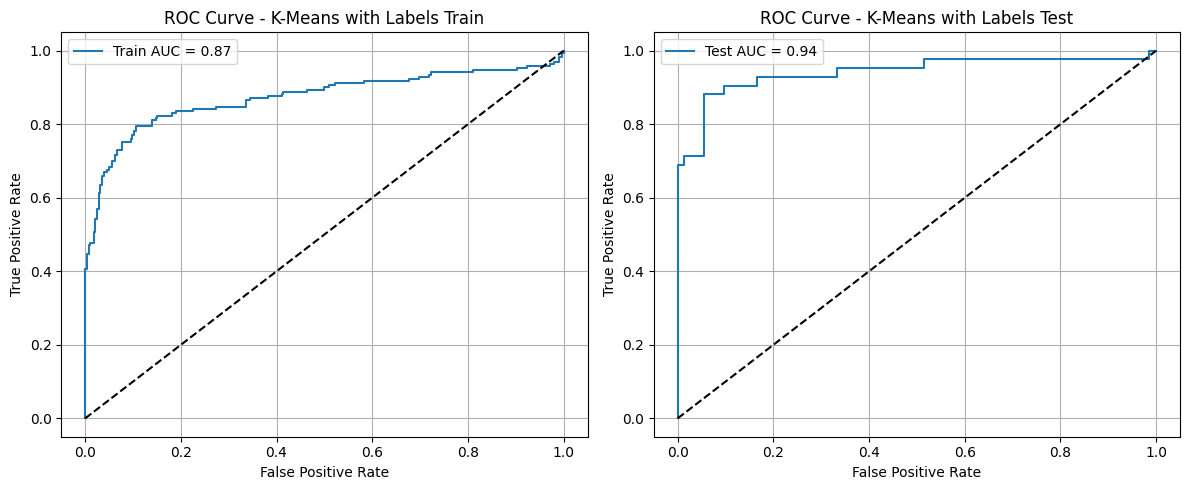

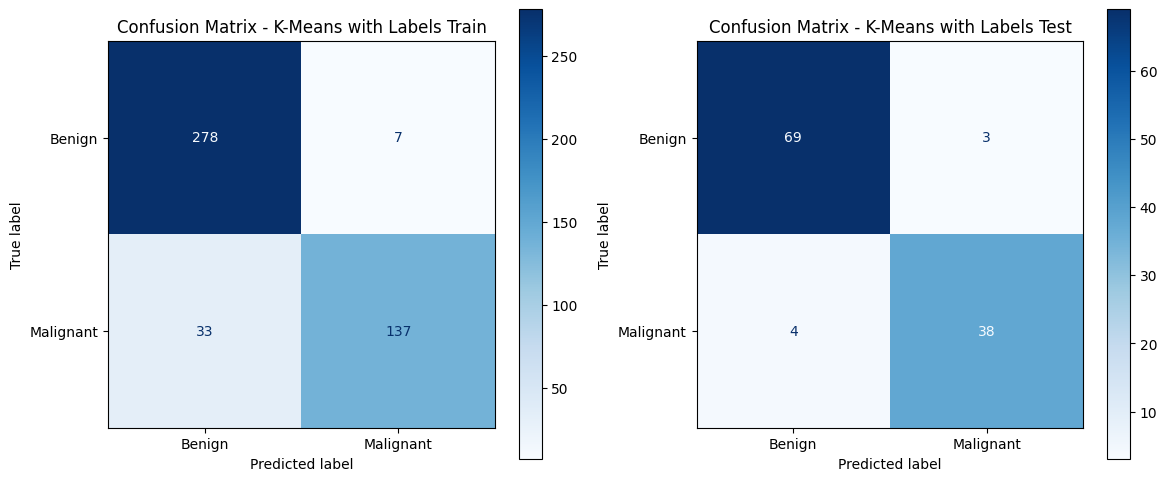

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
auc_train = roc_auc_score(y_train, y_train_proba)
axes[0].plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_title('ROC Curve - K-Means with Labels Train')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid()

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
auc_test = roc_auc_score(y_test, y_test_proba)
axes[1].plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title('ROC Curve - K-Means with Labels Test')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()
axes[1].grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Benign', 'Malignant'])
disp_train.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Confusion Matrix - K-Means with Labels Train')

cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Benign', 'Malignant'])
disp_test.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('Confusion Matrix - K-Means with Labels Test')
plt.tight_layout()
plt.show()


#### (iv) Spectral Clustering

c:\Users\kunfu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\kunfu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 442 with accuracies 
[4.58562223e-15 6.14313598e-05 8.45291095e-06]
not reaching the requested tolerance 8.478760719299316e-06.
Use iteration 407 instead with accuracy 
1.1056278575100347e-05.

  _, diffusion_map = lobpcg(
c:\Users\kunfu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.04553347e-15 9.93060248e-06 2.32382333e-05]
not reaching the requested tolerance 8.478760719299316e-06.
  _, diffusion_map = lobpcg(
c:\Users\kunfu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectr

Spectral Clustering Accuracy - Train: 0.9089 ± 0.0058, Test: 0.9143 ± 0.0210
Spectral Clustering Precision - Train: 0.9269 ± 0.0121, Test: 0.9277 ± 0.0311
Spectral Clustering Recall - Train: 0.8212 ± 0.0197, Test: 0.8333 ± 0.0503
Spectral Clustering F1 - Train: 0.8706 ± 0.0095, Test: 0.8770 ± 0.0318
Spectral Clustering Auc - Train: 0.9981 ± 0.0006, Test: 0.9839 ± 0.0116


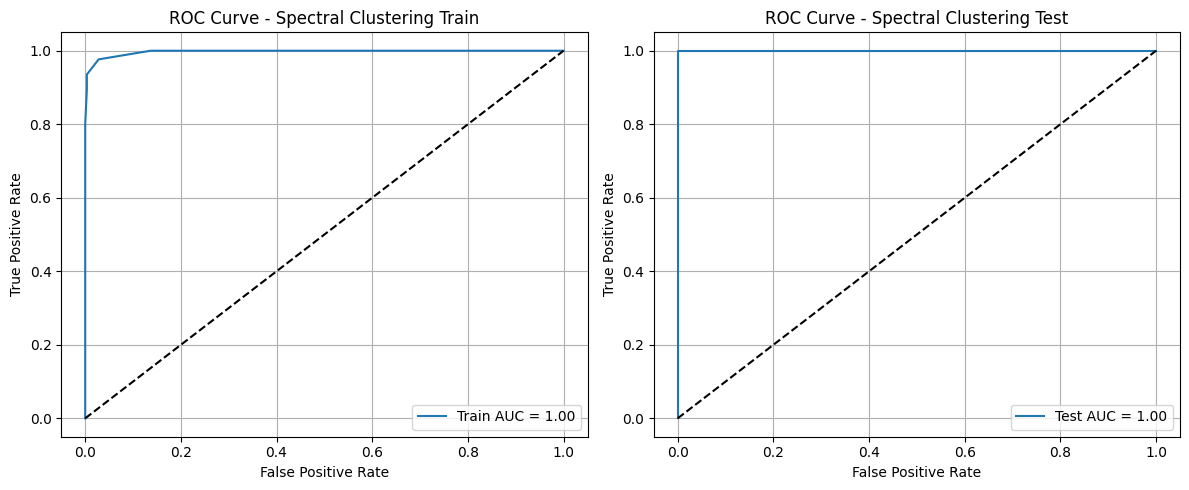

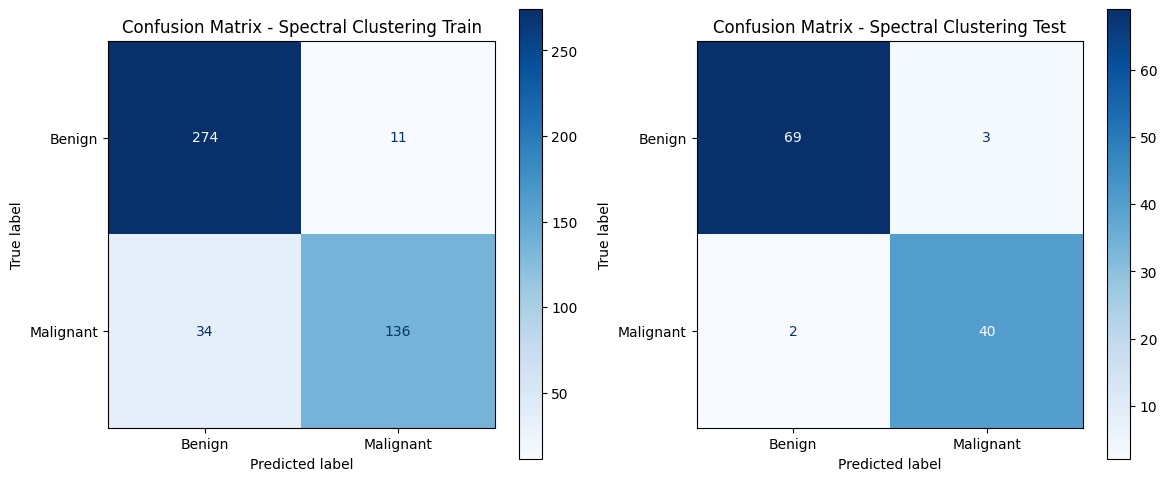

In [9]:
n_pos = np.sum(y == 1)
n_neg = np.sum(y == 0)
target_ratio = n_pos / n_neg

gamma_candidates = [0.001, 0.01, 0.1, 1, 2, 5, 10]
best_gamma = 1.0
best_balance = float('inf')

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

for gamma in gamma_candidates:
    spectral = SpectralClustering(n_clusters=2, affinity='rbf', gamma=gamma, n_init=10, random_state=42)
    clusters = spectral.fit_predict(x_scaled)

    cluster_0 = np.sum(clusters == 0)
    cluster_1 = np.sum(clusters == 1)
    cluster_ratio = min(cluster_0, cluster_1) / max(cluster_0, cluster_1)
    balance = abs(cluster_ratio - target_ratio)

    if balance < best_balance:
        best_balance = balance
        best_gamma = gamma

res_spectral = {
    'train': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []},
    'test': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
}
    
for run in range(M):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, stratify=y, random_state=run
    )

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    spectral = SpectralClustering(n_clusters=2, affinity='rbf', gamma=best_gamma, n_init=10, random_state=run, assign_labels='kmeans', eigen_tol=1e-5, n_neighbors=10)
    train_clusters = spectral.fit_predict(x_train_scaled)

    knn_clussifier = KNeighborsClassifier(n_neighbors=5)
    knn_clussifier.fit(x_train_scaled, train_clusters)
    test_clusters = knn_clussifier.predict(x_test_scaled)

    cluster_0 = np.sum((train_clusters == 0) & (y_train == 1))
    cluster_1 = np.sum((train_clusters == 1) & (y_train == 1))

    if cluster_0 >= cluster_1:
        y_train_pred = 1 - train_clusters
        y_test_pred = 1 - test_clusters
        malignant_cluster = 0
    else:
        y_train_pred = train_clusters
        y_test_pred = test_clusters
        malignant_cluster = 1

    knn_proba = KNeighborsClassifier(n_neighbors=5)
    knn_proba.fit(x_train_scaled, y_train)
    y_train_proba = knn_proba.predict_proba(x_train_scaled)[:, 1]
    y_test_proba = knn_proba.predict_proba(x_test_scaled)[:, 1]

    res_spectral['train']['accuracy'].append(accuracy_score(y_train, y_train_pred))
    res_spectral['train']['precision'].append(precision_score(y_train, y_train_pred))
    res_spectral['train']['recall'].append(recall_score(y_train, y_train_pred))
    res_spectral['train']['f1'].append(f1_score(y_train, y_train_pred))
    res_spectral['train']['auc'].append(roc_auc_score(y_train, y_train_proba))

    res_spectral['test']['accuracy'].append(accuracy_score(y_test, y_test_pred))
    res_spectral['test']['precision'].append(precision_score(y_test, y_test_pred))
    res_spectral['test']['recall'].append(recall_score(y_test, y_test_pred))
    res_spectral['test']['f1'].append(f1_score(y_test, y_test_pred))
    res_spectral['test']['auc'].append(roc_auc_score(y_test, y_test_proba))

for metrics in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    train_mean = np.mean(res_spectral['train'][metrics])
    train_std = np.std(res_spectral['train'][metrics])
    test_mean = np.mean(res_spectral['test'][metrics])
    test_std = np.std(res_spectral['test'][metrics])
    
    print(f"Spectral Clustering {metrics.capitalize()} - Train: {train_mean:.4f} ± {train_std:.4f}, Test: {test_mean:.4f} ± {test_std:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
auc_train = roc_auc_score(y_train, y_train_proba)
axes[0].plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_title('ROC Curve - Spectral Clustering Train')
axes[0].set_xlabel('False Positive Rate') 
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid()

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
auc_test = roc_auc_score(y_test, y_test_proba)
axes[1].plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title('ROC Curve - Spectral Clustering Test')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()
axes[1].grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Benign', 'Malignant'])
disp_train.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Confusion Matrix - Spectral Clustering Train')

cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Benign', 'Malignant'])
disp_test.plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title('Confusion Matrix - Spectral Clustering Test')
plt.tight_layout()
plt.show()



    

#### (v) Compare

In [10]:
compare = {
    'Supervised': res_supervised,
    'Semi-supervised A':  res_semi_a,
    'Semi-supervised B': res_semi_b,
    'K-Means A': res_kmeans_a,
    'K-Means B': res_kmeans_b,
    'Spectral Clustering': res_spectral
}
metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'auc']
for metrics in metrics_list:
    print(f"\n{metrics.capitalize()} Comparison")
    for method, results in compare.items():
        test_mean = np.mean(results['test'][metrics])
        test_std = np.std(results['test'][metrics])
        print(f"{method}: Test {metrics.capitalize()}: {test_mean:.4f} ± {test_std:.4f}") 

print("Unsepervised methodes achieve greater performance withouth any labels")
print("Spectral clustering is highly effective for cost-sensitive scenarios")
print("")


Accuracy Comparison
Supervised: Test Accuracy: 0.9661 ± 0.0128
Semi-supervised A: Test Accuracy: 0.9605 ± 0.0164
Semi-supervised B: Test Accuracy: 0.9614 ± 0.0119
K-Means A: Test Accuracy: 0.9064 ± 0.0213
K-Means B: Test Accuracy: 0.9064 ± 0.0213
Spectral Clustering: Test Accuracy: 0.9143 ± 0.0210

Precision Comparison
Supervised: Test Precision: 0.9876 ± 0.0155
Semi-supervised A: Test Precision: 0.9897 ± 0.0142
Semi-supervised B: Test Precision: 0.9702 ± 0.0295
K-Means A: Test Precision: 0.9112 ± 0.0321
K-Means B: Test Precision: 0.9112 ± 0.0321
Spectral Clustering: Test Precision: 0.9277 ± 0.0311

Recall Comparison
Supervised: Test Recall: 0.9198 ± 0.0345
Semi-supervised A: Test Recall: 0.9024 ± 0.0414
Semi-supervised B: Test Recall: 0.9246 ± 0.0139
K-Means A: Test Recall: 0.8278 ± 0.0517
K-Means B: Test Recall: 0.8278 ± 0.0517
Spectral Clustering: Test Recall: 0.8333 ± 0.0503

F1 Comparison
Supervised: Test F1: 0.9521 ± 0.0189
Semi-supervised A: Test F1: 0.9435 ± 0.0247
Semi-superv

## 2. Active Learning Using Support Vector Machines

### (a) Download the banknote authentication Data Set

In [11]:
data_two = Path(r'../Homework 8 Data/data_banknote_authentication.txt')
df_two = pd.read_csv(data_two, header=None)
df_two.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']

x = df_two.drop('class', axis=1).values
y = df_two['class'].values

np.random.seed(42)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=472, stratify=y, random_state=42
)

### (b) Repeat each of the following two procedures 50 times

#### (i) Passive

In [12]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
n_runs = 50
n_iter = 90
pool = 10

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

test_c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
acc = []

for c in test_c_values:
    svm = LinearSVC(penalty='l1', dual=False, C=c, max_iter=10000, random_state=42)
    svm.fit(x_train_scaled, y_train)
    y_train_pred = svm.predict(x_train_scaled)
    accuracy = accuracy_score(y_train, y_train_pred)
    acc.append(accuracy)
    print(f"C= {c}: Training Accuracy={accuracy:.4f}")

c_range = [0.01, 0.1, 1, 10, 100]

N_folds = 3

pass_error = {i: [] for i in range(n_iter)}

for run in range(n_runs):
    np.random.seed(run)
    labeled_idx = np.array([], dtype=int)
    unlabeled_idx = np.arange(len(x_train))

    for iteration in range(n_iter):
        if len(unlabeled_idx) >= pool:
            selected = np.random.choice(unlabeled_idx, pool, replace=False)
        else:
            selected = unlabeled_idx

        labeled_idx = np.concatenate([labeled_idx, selected])
        unlabeled_idx = np.setdiff1d(unlabeled_idx, selected)

        x_labeled = x_train[labeled_idx]
        y_labeled = y_train[labeled_idx]

        if len(np.unique(y_labeled)) < 2:
            y_test_pred = np.full(len(y_test), y_labeled[0])
            error_rate = 1 - accuracy_score(y_test, y_test_pred)
            pass_error[iteration].append(error_rate)
            continue

        scaler = StandardScaler()
        x_labeled_scaled = scaler.fit_transform(x_labeled)
        x_test_scaled = scaler.transform(x_test)

        if len(x_labeled) < 50:
            best_c = 1.0
        else:
            n_folds = min(N_folds, min(np.sum(y_labeled == 0), np.sum(y_labeled == 1)))
            n_folds = max(2, n_folds)

            cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=run)

            svm = LinearSVC(penalty='l1', dual=False, max_iter=5000, random_state=run)
            grid = GridSearchCV(svm, param_grid={'C': c_range}, cv=cv, scoring='accuracy', n_jobs=-1)

            try:
                grid.fit(x_labeled_scaled, y_labeled)
                best_c = grid.best_params_['C']
            except:
                best_c = 1.0

        svm_final = LinearSVC(penalty='l1', dual=False, C=best_c, max_iter=10000, random_state=run)
        svm_final.fit(x_labeled_scaled, y_labeled)

        y_test_pred = svm_final.predict(x_test_scaled)
        error_rate = 1 - accuracy_score(y_test, y_test_pred)
        pass_error[iteration].append(error_rate)

passive_avg_error = [np.mean(pass_error[i]) for i in range(n_iter)]
passive_std_error = [np.std(pass_error[i]) for i in range(n_iter)]

for i in range(n_iter):
    print(f"Iteration {i+1}: Average Test Error Rate = {passive_avg_error[i]:.4f} ± {passive_std_error[i]:.4f}")


C= 0.001: Training Accuracy=0.8433
C= 0.01: Training Accuracy=0.9722
C= 0.1: Training Accuracy=0.9856
C= 1: Training Accuracy=0.9911
C= 10: Training Accuracy=0.9889
C= 100: Training Accuracy=0.9889
C= 1000: Training Accuracy=0.9889
Iteration 1: Average Test Error Rate = 0.1166 ± 0.0954
Iteration 2: Average Test Error Rate = 0.0607 ± 0.0391
Iteration 3: Average Test Error Rate = 0.0360 ± 0.0204
Iteration 4: Average Test Error Rate = 0.0332 ± 0.0210
Iteration 5: Average Test Error Rate = 0.0273 ± 0.0109
Iteration 6: Average Test Error Rate = 0.0250 ± 0.0094
Iteration 7: Average Test Error Rate = 0.0237 ± 0.0093
Iteration 8: Average Test Error Rate = 0.0227 ± 0.0129
Iteration 9: Average Test Error Rate = 0.0208 ± 0.0070
Iteration 10: Average Test Error Rate = 0.0209 ± 0.0081
Iteration 11: Average Test Error Rate = 0.0201 ± 0.0076
Iteration 12: Average Test Error Rate = 0.0193 ± 0.0088
Iteration 13: Average Test Error Rate = 0.0207 ± 0.0079
Iteration 14: Average Test Error Rate = 0.0192 ± 

#### (ii) Active

In [13]:
act_error = {i: [] for i in range(n_iter)}

for run in range(n_runs):
    np.random.seed(run)
    labeled_idx = np.array([], dtype=int)
    unlabeled_idx = np.arange(len(x_train))

    for iteration in range(n_iter):
        if iteration == 0:
            if len(unlabeled_idx) >= pool:
                selected = np.random.choice(unlabeled_idx, pool, replace=False)
            else:
                selected = unlabeled_idx
        else:
            x_labeled = x_train[labeled_idx]
            y_labeled = y_train[labeled_idx] 
            x_unlabeled = x_train[unlabeled_idx]

            if len(np.unique(y_labeled)) < 2:
                if len(unlabeled_idx) >= pool:
                    selected = np.random.choice(unlabeled_idx, pool, replace=False)
                else:
                    selected = unlabeled_idx
            else:
                scaler = StandardScaler()
                x_labeled_scaled = scaler.fit_transform(x_labeled)
                x_unlabeled_scaled = scaler.transform(x_unlabeled)

                temp_c = 1.0
                temp_svm = LinearSVC(penalty='l1', dual=False, C=temp_c, max_iter=5000, random_state=run)
                temp_svm.fit(x_labeled_scaled, y_labeled)

                decision_values = temp_svm.decision_function(x_unlabeled_scaled)

                n_selected = min(pool, len(unlabeled_idx))
                uncertainty_indices = np.argsort(np.abs(decision_values))[:n_selected]
                selected = unlabeled_idx[uncertainty_indices]

        labeled_idx = np.concatenate([labeled_idx, selected])
        unlabeled_idx = np.setdiff1d(unlabeled_idx, selected)

        x_labeled = x_train[labeled_idx]
        y_labeled = y_train[labeled_idx]

        if len(np.unique(y_labeled)) < 2:
            y_test_pred = np.full(len(y_test), y_labeled[0])
            error_rate = 1 - accuracy_score(y_test, y_test_pred)
            act_error[iteration].append(error_rate)
            continue

        scaler = StandardScaler()
        x_labeled_scaled = scaler.fit_transform(x_labeled)
        x_test_scaled = scaler.transform(x_test)

        if len(x_labeled) < 50:
            best_c = 1.0
        else:
            n_folds = min(5, min(np.sum(y_labeled == 0), np.sum(y_labeled == 1)))
            n_folds = max(2, n_folds)

            cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=run)
            svm = LinearSVC(penalty='l1', dual=False, max_iter=5000, random_state=run)
            grid = GridSearchCV(svm, param_grid={'C': c_range}, cv=cv, scoring='accuracy', n_jobs=-1)

            try:
                grid.fit(x_labeled_scaled, y_labeled)
                best_c = grid.best_params_['C']
            except:
                best_c = 1.0
        svm_final = LinearSVC(penalty='l1', dual=False, C=best_c, max_iter=5000, random_state=run)
        svm_final.fit(x_labeled_scaled, y_labeled)

        y_test_pred = svm_final.predict(x_test_scaled)
        error_rate = 1 - accuracy_score(y_test, y_test_pred)
        act_error[iteration].append(error_rate)

act_avg_error = [np.mean(act_error[i]) for i in range(n_iter)]
act_std_error = [np.std(act_error[i]) for i in range(n_iter)]

for i in range(n_iter):
    print(f"Iteration {i+1}: Average Test Error Rate = {act_avg_error[i]:.4f} ± {act_std_error[i]:.4f}")

Iteration 1: Average Test Error Rate = 0.1166 ± 0.0954
Iteration 2: Average Test Error Rate = 0.0543 ± 0.0412
Iteration 3: Average Test Error Rate = 0.0306 ± 0.0174
Iteration 4: Average Test Error Rate = 0.0179 ± 0.0083
Iteration 5: Average Test Error Rate = 0.0135 ± 0.0057
Iteration 6: Average Test Error Rate = 0.0094 ± 0.0032
Iteration 7: Average Test Error Rate = 0.0102 ± 0.0030
Iteration 8: Average Test Error Rate = 0.0093 ± 0.0017
Iteration 9: Average Test Error Rate = 0.0089 ± 0.0013
Iteration 10: Average Test Error Rate = 0.0091 ± 0.0015
Iteration 11: Average Test Error Rate = 0.0087 ± 0.0010
Iteration 12: Average Test Error Rate = 0.0086 ± 0.0006
Iteration 13: Average Test Error Rate = 0.0086 ± 0.0006
Iteration 14: Average Test Error Rate = 0.0089 ± 0.0013
Iteration 15: Average Test Error Rate = 0.0086 ± 0.0008
Iteration 16: Average Test Error Rate = 0.0086 ± 0.0008
Iteration 17: Average Test Error Rate = 0.0086 ± 0.0006
Iteration 18: Average Test Error Rate = 0.0085 ± 0.0000
I

### (c) Average the 50 test errors

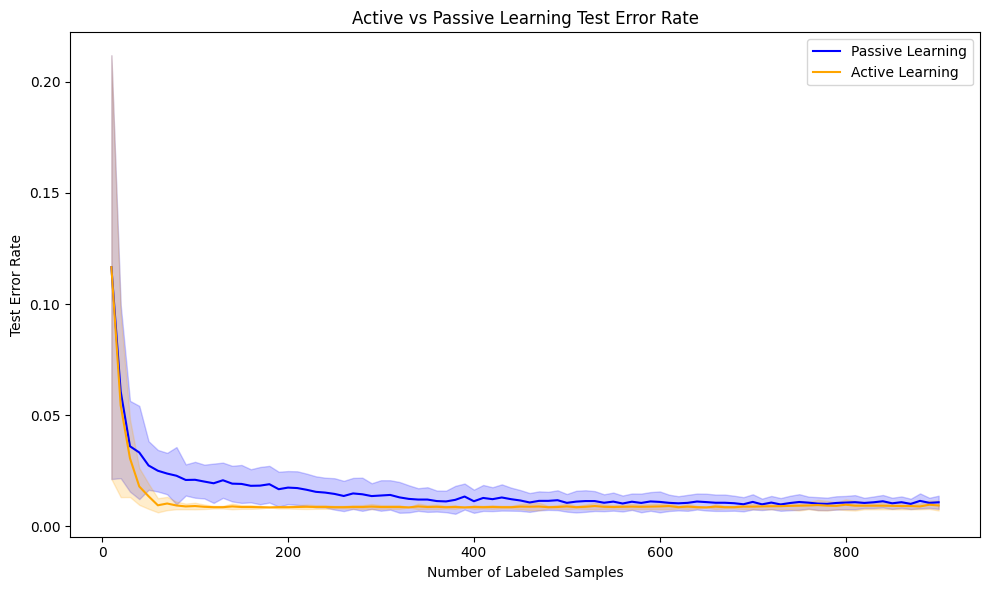

Active learning consistently outperforms passive learning, achieving lower error rates with fewer labeled samples.
Both methods converges to similar performance as the number of labeled samples increases.


In [15]:
pass_avg_error = [np.mean(pass_error[i]) for i in range(n_iter)]
pass_std_error = [np.std(pass_error[i]) for i in range(n_iter)]
act_avg_error = [np.mean(act_error[i]) for i in range(n_iter)]
act_std_error = [np.std(act_error[i]) for i in range(n_iter)]

sample_sizes = [(i + 1) * pool for i in range(n_iter)]

plt.figure(figsize=(10, 6))

plt.plot(sample_sizes, pass_avg_error, label='Passive Learning', color='blue')
plt.fill_between(sample_sizes, 
                 np.array(pass_avg_error) - np.array(pass_std_error), 
                 np.array(pass_avg_error) + np.array(pass_std_error), 
                 color='blue', alpha=0.2)

plt.plot(sample_sizes, act_avg_error, label='Active Learning', color='orange')
plt.fill_between(sample_sizes, 
                 np.array(act_avg_error) - np.array(act_std_error), 
                 np.array(act_avg_error) + np.array(act_std_error), 
                 color='orange', alpha=0.2)

plt.xlabel('Number of Labeled Samples')
plt.ylabel('Test Error Rate')
plt.title('Active vs Passive Learning Test Error Rate')
plt.legend()
plt.tight_layout()
plt.show()

print("Active learning consistently outperforms passive learning, achieving lower error rates with fewer labeled samples.")
print("Both methods converges to similar performance as the number of labeled samples increases.")